# DKTC v4 - TAPT + 대규모 일반대화 데이터 기반

## 참고
> - https://ratsgo.github.io/embedding/downloaddata.html (한국어 데이터)
> - https://github.com/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC (0.882 달성 전략)
> - "Don't Stop Pretraining" (Gururangan et al., 2020)

## v4 핵심 전략
- [v7-1] **TAPT (Task-Adaptive Pre-Training)**: klue/bert-base에 대화 데이터로 MLM 사전학습
- [v7-2] **대규모 일반대화 데이터**: korean_safe_conversation(10000) + KOTE(10000) + 기존 소스
- [v7-3] **klue/bert-base 모델**: 0.882 달성자와 동일 모델 사용

## 유지 전략 (v3~v6)
- K-Fold (5F) + R-Drop + Focal Loss
- LLRD + FGM + EMA + Label Smoothing
- Prior Shift Calibration + Threshold Optimization
- Hard Negative 경계 대화 200개
- Confidence-based Hard Sample Mining + Dynamic Class Weight
- 체크포인트 저장/복구 (런타임 끊김 대비)

In [1]:
# 폰트 확인 (이미 설치됨)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fonts = [f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name]
assert fonts, "NanumGothic 폰트가 없습니다!"
print(f"NanumGothic 폰트 OK: {fonts}")

NanumGothic 폰트 OK: ['NanumBarunGothic', 'NanumSquareRound', 'NanumGothic', 'NanumMyeongjo', 'NanumBarunGothic', 'NanumSquare', 'NanumSquareRound', 'NanumGothic', 'NanumGothicCoding', 'NanumSquare', 'NanumMyeongjo', 'NanumGothicCoding']


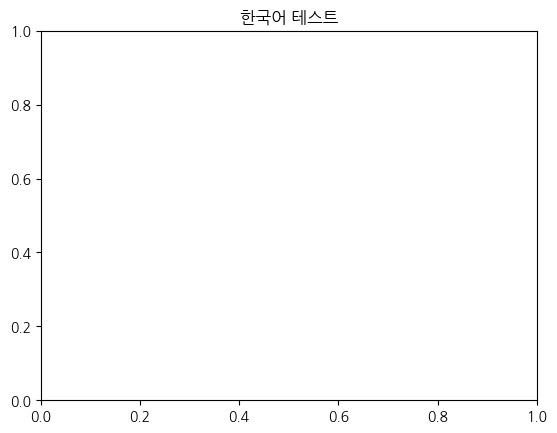

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure()
plt.title('한국어 테스트')
plt.show()

In [3]:
# ============================================================
# STEP 0-2: 라이브러리 + 데이터 확인 (이미 설치/다운로드 완료)
# ============================================================
import transformers, datasets, accelerate, sklearn, matplotlib, seaborn, pandas
import os

print(f"transformers {transformers.__version__}")
print(f"datasets {datasets.__version__}")

for f in ["smilestyle_dataset.tsv", "KakaoData.csv", "nsmc_train.txt"]:
    assert os.path.exists(f), f"{f} 파일이 없습니다!"
    print(f"  [OK] {f} ({os.path.getsize(f):,} bytes)")

print("설치 및 다운로드 완료!")

/home/ubuntu/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


transformers 5.1.0
datasets 4.5.0
  [OK] smilestyle_dataset.tsv (2,357,401 bytes)
  [OK] KakaoData.csv (8,044,757 bytes)
  [OK] nsmc_train.txt (14,628,807 bytes)
설치 및 다운로드 완료!


In [4]:
import os
DATA_DIR = '/home/ubuntu/lambda-fs'
os.chdir(DATA_DIR)

for f in ['train.csv', 'test.csv', 'submission.csv']:
    if os.path.exists(f):
        print(f"  [OK] {f}")
    else:
        print(f"  [!!] {f} 없음")

print(f"\n작업 폴더: {os.getcwd()}")

  [OK] train.csv
  [OK] test.csv
  [OK] submission.csv

작업 폴더: /lambda/nfs/lambda-fs


In [5]:
import os, random, re, gc, copy, pickle, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
    AutoModelForMaskedLM, DataCollatorForLanguageModeling,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from datasets import load_dataset
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA H100 80GB HBM3


In [6]:
# ============================================================
# 클래스 매핑 + 하이퍼파라미터 (v7)
# ============================================================
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']
CLASS2IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}
IDX2CLASS = {idx: name for idx, name in enumerate(CLASS_NAMES)}
NUM_CLASSES = 5

# [v7-3] klue/bert-base (0.882 달성 모델)
BASE_MODEL = 'klue/bert-base'

CKPT_DIR = os.path.join(DATA_DIR, 'v7_ckpts')
os.makedirs(CKPT_DIR, exist_ok=True)

# [v7-1] TAPT 설정
TAPT_SAVE_DIR = os.path.join(CKPT_DIR, 'tapt_model')
TAPT_EPOCHS = 5
TAPT_LR = 2e-5
TAPT_BATCH_SIZE = 16
TAPT_MLM_PROB = 0.15

# Fine-tuning 모델 설정
MODEL_CONFIGS = [
    {'name': TAPT_SAVE_DIR, 'short': 'KLUE-BERT-TAPT'},
]

MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 5
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.2  # 0.882 달성자 참고: LR scheduler 0.2
MAX_GRAD_NORM = 1.0
N_FOLDS = 5
PSEUDO_THRESHOLD = 0.95

# v4 techniques
LLRD_FACTOR = 0.95
FGM_EPSILON = 1.0
LABEL_SMOOTHING = 0.05
EMA_DECAY = 0.999

# v5 test distribution estimate
EST_TEST_DIST = {0: 39, 1: 23, 2: 21, 3: 39, 4: 378}

# v6 quality filter
MIN_TEXT_LEN = 15
MAX_TEXT_LEN = 500
MAX_SPECIAL_RATIO = 0.3

print("v7 설정 완료")
print(f"베이스 모델: {BASE_MODEL}")
print(f"TAPT: {TAPT_EPOCHS}ep, lr={TAPT_LR}, mlm_prob={TAPT_MLM_PROB}")
print(f"Fine-tune: {EPOCHS}ep, lr={LR}, warmup={WARMUP_RATIO}")
print(f"체크포인트: {CKPT_DIR}")

v7 설정 완료
베이스 모델: klue/bert-base
TAPT: 5ep, lr=2e-05, mlm_prob=0.15
Fine-tune: 5ep, lr=2e-05, warmup=0.2
체크포인트: /home/ubuntu/lambda-fs/v7_ckpts


In [7]:
# ============================================================
# STEP 1: 데이터 로드
# ============================================================
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('submission.csv')

print(f"Train: {len(train_df)}개, Test: {len(test_df)}개")
print(f"클래스 분포:\n{train_df['class'].value_counts()}")
print(f"\n>> '일반 대화' 0개 -> STEP 2에서 대규모 합성 (v7: TAPT용 데이터 포함)")

Train: 3950개, Test: 500개
클래스 분포:
class
기타 괴롭힘 대화      1094
갈취 대화           981
직장 내 괴롭힘 대화     979
협박 대화           896
Name: count, dtype: int64

>> '일반 대화' 0개 -> STEP 2에서 대규모 합성 (v7: TAPT용 데이터 포함)


In [8]:
# ============================================================
# STEP 2: [v7-2] 대규모 합성 일반대화 + Hard Negative Mining
# ============================================================
# 참고: 0.882 달성자 전략
#   한국어 SNS 5000 + 한국어 대화 5000 + 감성 말뭉치 5000 + 오분류 350
# v7: HuggingFace에서 다운로드 가능한 대화 데이터로 대체
# ============================================================
THREAT_KEYWORDS = [
    '죽여', '죽일', '찔러', '칼로', '패줄', '두들겨', '불질러',
    '협박', '신고', '경찰', '감옥', '고소', '소송',
    '돈 내놔', '송금', '이자', '빚', '갚아',
    '해고', '짤리', '사직서', '퇴사', '상사',
    '따돌', '왕따', '무시', '괴롭'
]

def contains_threat(text):
    return any(kw in str(text) for kw in THREAT_KEYWORDS)

normal_samples = []

# ── 소스 1: SmileStyle 개별 문장 (1200개) ──
print("소스 1: SmileStyle (개별 문장)")
try:
    smile_df = pd.read_csv('smilestyle_dataset.tsv', sep='\t')
    target_cols = [c for c in smile_df.columns
                   if any(kw in c.lower() for kw in ['informal', 'chat', '반말', 'casual'])]
    if not target_cols:
        target_cols = smile_df.columns[1:].tolist()
    smile_texts = []
    for col in target_cols:
        smile_texts.extend(smile_df[col].dropna().tolist())
    smile_filtered = [str(t).strip() for t in smile_texts
                      if not contains_threat(t) and 15 < len(str(t).strip()) < 300]
    random.shuffle(smile_filtered)
    normal_samples.extend(smile_filtered[:1200])
    print(f"  -> {min(1200, len(smile_filtered))}개 수집")
except Exception as e:
    print(f"  오류: {e}")

# ── 소스 2: kor_unsmile 클린 개별 문장 (800개) ──
print("소스 2: kor_unsmile (개별 문장)")
try:
    unsmile_ds = load_dataset('smilegate-ai/kor_unsmile', split='train')
    unsmile_df = unsmile_ds.to_pandas()
    if 'clean' in unsmile_df.columns:
        clean_texts = unsmile_df[unsmile_df['clean'] == 1]['문장'].tolist()
    else:
        label_cols = [c for c in unsmile_df.columns if c not in ['문장', 'clean']]
        clean_mask = unsmile_df[label_cols].sum(axis=1) == 0
        clean_texts = unsmile_df[clean_mask]['문장'].tolist()
    clean_filtered = [str(t).strip() for t in clean_texts
                      if not contains_threat(t) and 10 < len(str(t).strip()) < 300]
    random.shuffle(clean_filtered)
    normal_samples.extend(clean_filtered[:800])
    print(f"  -> {min(800, len(clean_filtered))}개 수집")
except Exception as e:
    print(f"  오류: {e}")

# ── 소스 3: KakaoChatData Q+A 쌍 (500개) ──
print("소스 3: KakaoChatData (Q+A 쌍)")
try:
    kakao_df = pd.read_csv('KakaoData.csv')
    kakao_pairs = []
    for _, row in kakao_df.iterrows():
        q = str(row.get('Q', row.iloc[0]))
        a = str(row.get('A', row.iloc[1]))
        conv = f"{q} {a}"
        if not contains_threat(conv) and 20 < len(conv) < 400:
            kakao_pairs.append(conv)
    random.shuffle(kakao_pairs)
    normal_samples.extend(kakao_pairs[:500])
    print(f"  -> {min(500, len(kakao_pairs))}개 수집")
except Exception as e:
    print(f"  오류: {e} (건너뜀)")

# ── 소스 4: NSMC 긍정 리뷰 개별 문장 (500개) ──
print("소스 4: NSMC (개별 문장)")
try:
    nsmc_df = pd.read_csv('nsmc_train.txt', sep='\t')
    positive = nsmc_df[nsmc_df['label'] == 1]['document'].dropna().tolist()
    pos_filtered = [str(t).strip() for t in positive
                    if not contains_threat(t) and 15 < len(str(t).strip()) < 200]
    random.shuffle(pos_filtered)
    normal_samples.extend(pos_filtered[:500])
    print(f"  -> {min(500, len(pos_filtered))}개 수집")
except Exception as e:
    print(f"  오류: {e}")

# ══════════════════════════════════════════════════════════════
# [v7-2 NEW] 소스 5: korean_safe_conversation (10000개)
# HuggingFace: jojo0217/korean_safe_conversation
# ══════════════════════════════════════════════════════════════
print("소스 5: [v7-2] korean_safe_conversation (HuggingFace)")
try:
    safe_ds = load_dataset('jojo0217/korean_safe_conversation', split='train')
    safe_df = safe_ds.to_pandas()
    # instruction + output 합쳐서 대화 텍스트 생성
    safe_texts = []
    for _, row in safe_df.iterrows():
        instr = str(row.get('instruction', '')).strip()
        outp = str(row.get('output', '')).strip()
        conv = f"{instr} {outp}".strip()
        if conv:
            safe_texts.append(conv)
    safe_filtered = [t for t in safe_texts
                     if not contains_threat(t) and 10 < len(t) < 500]
    random.shuffle(safe_filtered)
    normal_samples.extend(safe_filtered[:10000])
    print(f"  -> {min(10000, len(safe_filtered))}개 수집 (총 {len(safe_texts)}개 중)")
except Exception as e:
    print(f"  오류: {e}")
    print("  -> 건너뜀")

# ══════════════════════════════════════════════════════════════
# [v7-2 NEW] 소스 6: KOTE 감성 대화 (3000개)
# HuggingFace: searle-j/KOTE
# ══════════════════════════════════════════════════════════════
print("소스 6: [v7-2] kor_nli 한국어 문장 (HuggingFace)")
try:
    nli_ds = load_dataset('kor_nli', 'multi_nli', split='train')
    nli_df = nli_ds.to_pandas()
    nli_texts = nli_df['premise'].dropna().tolist() + nli_df['hypothesis'].dropna().tolist()
    nli_filtered = [str(t).strip() for t in nli_texts
                    if not contains_threat(t) and 10 < len(str(t).strip()) < 500]
    random.shuffle(nli_filtered)
    normal_samples.extend(nli_filtered[:10000])
    print(f"  -> {min(10000, len(nli_filtered))}개 수집 (총 {len(nli_texts)}개 중)")
except Exception as e:
    print(f"  오류: {e}")
    print("  -> 건너뜀")

# ══════════════════════════════════════════════════════════════
# 소스 7: Hard Negative 경계 대화 (200개) - v6에서 유지
# ══════════════════════════════════════════════════════════════
print("소스 7: Hard Negative 경계 대화 (v6 유지)")
hard_negatives = [
    # HN-A: 협박 ↔ 정당한 경고/항의/비유적 표현 (50개)
    "야 죽을래 ㅋㅋ 아 진짜 웃겨서 죽겠다 아 배아파 ㅋㅋㅋ 진짜 미쳤어 너 개그맨 해라",
    "야 너 진짜 맞을래 ㅋㅋ 아 왜 그런 말을 해서 웃기게 만들어 아 진짜 복근 생기겠다",
    "죽여버린다 ㅋㅋ 아 이 게임 왜 이렇게 어려워 보스 죽여버리고 싶다 진짜",
    "패버리고 싶다 ㅋㅋ 누구를 이 게임 캐릭터 진짜 짜증나 아 다시 해야지",
    "칼로 자르고 싶다 뭘 이 케이크 너무 예뻐서 자르기 아까운데 먹어야지",
    "야 한대 맞을래 ㅋㅋㅋ 농담이야 근데 진짜 왜 그런 얘기를 해 아 웃겨",
    "미쳤어 진짜 ㅋㅋ 이 짤 봤어 와 진짜 웃겨서 죽는줄 알았어 보내줄까",
    "너 진짜 미쳤다 ㅋㅋ 이걸 어떻게 생각해내 와 천재 아니야 대단하다 진짜",
    "야 너 오늘 죽었다 ㅋㅋ 왜 노래방에서 내 노래 뺏어서 불렀잖아 다음엔 내가 먼저",
    "때려치우고 싶다 뭘 회사 오늘 진짜 힘들었어 야 치킨 먹자 나 오늘 자격 있어",
    "경찰 부를거야 ㅋㅋ 왜 너 방 너무 더러워서 환경오염 신고해야 할 것 같아",
    "고소할거야 진짜 ㅋㅋ 왜 네가 나한테 이렇게 맛있는 걸 안 알려줬어 배신자",
    "불질러버리고 싶다 뭘 이 과제 너무 많아서 다 태워버리고 싶어 ㅋㅋ 농담이야",
    "찔러버린다 ㅋㅋ 뭘 이 젤리 포크로 찔러서 먹어야 하는데 손으로 먹었어",
    "감옥에 넣어야 해 ㅋㅋ 누구를 이렇게 늦게 연락하는 너를 지각죄로 가둬야지",
    "층간소음 계속되면 관리사무소에 정식으로 민원 넣을 거예요 녹음도 다 해뒀습니다",
    "다시 한번 이런 일 생기면 소비자보호원에 신고하겠습니다 영수증 다 보관하고 있어요",
    "제가 법률 상담 받아봤는데요 이건 충분히 손해배상 청구 가능하다고 합니다",
    "경찰에 신고하겠습니다 왜냐면 제 물건을 허락 없이 가져간 건 절도에 해당하거든요",
    "노동청에 진정서 넣을 수 있다는 거 알고 계시죠 근로기준법 위반이에요",
    "CCTV 영상 확보했으니까 다음에 또 그러시면 법적으로 대응하겠습니다",
    "이거 소비자 분쟁 조정위원회에 접수할게요 교환이나 환불 해주셔야 합니다",
    "변호사 선임해서 내용증명 보내겠습니다 이건 명백한 계약 위반이에요",
    "학교 폭력 신고 접수하겠습니다 증거 자료 다 모아놨어요 상담 선생님한테 먼저 얘기할게요",
    "이 문제 공정거래위원회에 제보하겠습니다 허위 광고에 해당하는 것 같아요",
    "아 죽겠다 진짜 더워서 에어컨 좀 틀어줘 녹을 것 같아",
    "너 진짜 죽인다 노래 진짜 잘 부른다 가수 해도 되겠다 대박",
    "아 맞아 죽겠어 ㅋㅋ 이 운동 진짜 힘들다 근데 끝나면 개운하긴 해",
    "야 폭발할 것 같아 뭐가 시험 스트레스 아 빨리 끝나라",
    "터질 것 같다 ㅋㅋ 뭐가 밥을 너무 많이 먹었어 배 터지겠어",
    "미쳐버리겠다 진짜 ㅋㅋ 이 드라마 반전 뭐야 소름 돋았어",
    "아 진짜 때리고 싶다 ㅋㅋ 누구를 이 알람 시계 매일 아침마다 짜증나",
    "날려버리고 싶다 뭘 이 다이어트 오늘부터 야식 안 먹는다 진짜로",
    "밟아버린다 ㅋㅋ 뭘 이 게임 점수 내가 이번에 꼭 이긴다 두고 봐",
    "찢었다 ㅋㅋ 뭘 시험 만점 받았어 공부한 보람이 있다",
    "박살 내버렸다 ㅋㅋ 뭘 노래방 점수 100점 나왔어 나 천재인듯",
    "야 너 오늘 끝장이다 ㅋㅋ 뭐가 볼링 내기에서 졌으니까 밥 사야지",
    "가만 안 둔다 ㅋㅋ 누구를 내 과자 먹은 사람 당장 자수해",
    "불태워버리겠다 ㅋㅋ 뭘 이번 축제 무대 내가 완전 불태울거야 기대해",
    "난리 난다 ㅋㅋ 왜 엄마가 성적표 보면 난리 나겠다 미리 말해야지",
    "각오해 ㅋㅋ 뭘 다음 게임 내가 연습 많이 했거든 이번엔 진다",
    "복수한다 ㅋㅋ 어떻게 다음에 술래잡기 할 때 내가 꼭 잡을거야",
    "잡아먹겠다 ㅋㅋ 누구를 이 떡볶이 너무 맛있어서 다 먹어버리겠어",
    "쓸어버린다 ㅋㅋ 뭘 대청소 시작이다 방 깨끗하게 만들어야지",
    "혼내준다 ㅋㅋ 누구를 동생이 내 옷 빌려 입었어 귀엽긴 한데",

    # HN-B: 갈취 ↔ 상호 호혜적 금전 거래/친밀한 요청 (50개)
    "돈 내놔 ㅋㅋ 밥값 네가 쏜다며 아 맞다 내가 쏜다고 했지 ㅋㅋ 어디 갈까",
    "야 천원만 빌려줘 자판기 커피 마시고 싶은데 지갑을 놓고 왔어 내일 바로 갚을게",
    "야 그거 빌려줘 뭘 충전기 배터리 없어서 잠깐만 쓸게 고마워",
    "밥 사라 ㅋㅋ 야 오늘 내 생일인데 당연히 네가 사야지 어디 갈까",
    "용돈 다 썼어 ㅋㅋ 야 오늘 커피 한잔만 사줘 다음에 내가 쏠게 진짜로",
    "야 택시비 좀 보태줘 3천원만 있으면 되는데 집에 가야 해 내일 바로 보내줄게",
    "야 이거 줘 뭐 그 펜 좀 잠깐만 쓸게 아 고마워 나중에 돌려줄게",
    "돈 있어 얼마 만원만 있으면 되는데 같이 밥 먹으러 가자 내가 부족한 부분 낼게",
    "야 담배 한 개비 줘봐 아 나 오늘 스트레스 받아서 한 대만 ㅋㅋ 고마워 내일 사줄게",
    "이거 나 좀 줘 뭐 이 과자 맛있어 보여서 하나만 줘봐 오 진짜 맛있다",
    "저번에 네가 빌려준 3만원 오늘 갚을게 카카오페이로 보낼까 계좌로 보낼까",
    "이번 달 회비 만원씩 걷는 거 맞지 내가 총무니까 내일까지 보내줘",
    "야 우리 생일 선물 5만원 이하로 하기로 했잖아 뭐 사줄까 고민 중이야",
    "더치페이 하자 각자 먹은 만큼 내는 게 편하지 않아 나 파스타 먹었으니까 만오천원",
    "축의금 얼마 내야 하지 우리 사이면 5만원 정도면 괜찮을까 같이 내자",
    "엄마 생신 선물 같이 사자 우리 삼남매 나눠서 내면 한 명당 3만원이면 되지",
    "동아리 엠티 비용 인당 5만원이래 참가비 내일까지 총무한테 보내면 돼",
    "이사 도와줘서 고마워 저녁 내가 쏠게 치킨이랑 맥주 어때 골라",
    "야 내가 빌린 우산 돌려줄게 다음에 만날 때 가져갈게 미안 계속 잊어버렸어",
    "카풀 기름값 나눠 내자 왕복 2시간이니까 만원씩만 내면 될 것 같아 괜찮지",
    "야 내기 했으니까 진 사람이 아이스크림 사는 거다 ㅋㅋ 나 딸기맛으로",
    "선배 커피 사드려야 하는데 같이 돈 모으자 한 명당 천원이면 되잖아",
    "생일 파티 준비물 내가 케이크 살게 너는 음료수 사와 나중에 정산하자",
    "야 택배비 반만 내줘 같이 시킨 거잖아 2500원씩 나누면 되지",
    "정기 모임 식비 만오천원이래 다음 달 거 미리 내도 돼 한꺼번에 정리하게",
    "중고로 팔 건데 너 혹시 살래 원래 5만원인데 친구니까 3만원에 줄게",
    "야 내 교통카드 잔액 부족한데 한번만 찍어줘 집 가서 바로 송금할게",
    "결혼 축하해 축의금은 당일에 직접 줄게 봉투 준비해뒀어",
    "아르바이트 월급 들어왔다 저번에 빌린 거 오늘 보내줄게 얼마였더라",
    "회식비 각자 부담이래 메뉴 고르자 예산 인당 2만원 정도면 괜찮겠다",
    "야 주차비 내가 낼게 네가 운전해줬으니까 이 정도는 내가 내야지",
    "보증금 돌려받으면 빌린 거 갚을게 이번 달 말에 나온대 조금만 기다려줘",
    "야 이거 반값 할인이다 같이 사면 배송비 무료래 나눠 갖자",
    "점심값 내가 카드로 긁었으니까 너 몫 만이천원 보내줘 카카오페이로",
    "엄마한테 용돈 받으면 갚을게 진짜 미안 이번 달만 좀 도와줘",
    "여행 경비 미리 걷자 항공권이랑 숙소비 합치면 인당 30만원 정도야",
    "야 내가 대신 결제했으니까 네 몫 나중에 줘 급한 거 아니니까 천천히",
    "문화상품권 남는 거 있으면 하나만 줘 게임 아이템 사고 싶은데 부족해",
    "야 커피 한잔 사줄래 오늘 내가 발표 잘 했거든 축하 의미로 ㅎㅎ",
    "오늘 간식 내가 쏠게 편의점에서 뭐 먹고 싶어 골라 내가 계산할게",

    # HN-C: 직장괴롭힘 ↔ 엄격하지만 정당한 업무 지시 (50개)
    "오늘 야근이야 또 아 진짜 힘들다 그래도 이번 프로젝트 끝나면 좀 쉴 수 있겠지",
    "상사가 또 일 줬어 근데 뭐 그래도 인정해주니까 열심히 해야지 파이팅",
    "퇴사하고 싶다 ㅋㅋ 아 농담이야 월급날이니까 참는거지 오늘 뭐 먹을까",
    "야 우리 부장님 또 회식 잡았대 아 귀찮다 그래도 고기니까 ㅋㅋ 가자",
    "아 오늘 진짜 일 많다 죽겠어 ㅋㅋ 그래도 퇴근하면 치맥이다 버텨보자",
    "팀장님이 또 수정해달래 세번째야 근데 뭐 덕분에 더 좋아지긴 했어 감사하지",
    "인사팀에서 면담하자고 했어 뭐래 아 그냥 만족도 조사래 놀랐잖아 ㅋㅋ",
    "해고당할뻔 했어 ㅋㅋ 왜 아 늦잠자서 지각했는데 부장님이 웃으면서 넘어가줬어 휴",
    "사직서 쓸뻔 했다 ㅋㅋ 왜 프린터가 안 돼서 30분 싸웠어 결국 고쳤어",
    "회의 또 해 진짜 오늘만 세번째야 그래도 뭐 좋은 아이디어 나왔으니까 괜찮아",
    "이 보고서 데이터 검증이 안 되어 있네요 출처 명시하고 수치 다시 확인해서 내일 오전까지 재출해주세요",
    "납기가 이틀 남았습니다 지금 진행 상황 공유해주시고 지연 사유 있으면 미리 말씀해주세요",
    "이번 기획안은 고객 니즈 분석이 부족합니다 시장조사 데이터 추가해서 보완해주세요",
    "코드 리뷰 결과 예외 처리가 빠져있어요 에러 케이스 추가하고 테스트 코드도 작성해주세요",
    "프레젠테이션 자료 글씨가 너무 작아요 핵심 메시지 위주로 슬라이드 재구성 부탁드립니다",
    "회의 때 말씀드린 대로 일정 조정해서 공유해주세요 관련 부서 협의도 같이 진행해주시고요",
    "이 디자인 컨셉은 브랜드 가이드라인과 맞지 않아요 색상과 폰트 가이드라인 확인하고 수정해주세요",
    "주간 보고서 금요일까지 제출입니다 아직 안 내신 분들 오늘 중으로 부탁드려요",
    "테스트 결과서에 버그 세 건 누락되어 있어요 전수 조사 다시 하고 정리해서 올려주세요",
    "이번 제안서 경쟁사 분석 파트가 미흡합니다 벤치마킹 자료 보강해서 화요일까지 수정본 부탁합니다",
    "야근비 신청하세요 오늘 늦게까지 수고했는데 당연히 받아야죠 내일은 좀 일찍 들어가세요",
    "신입분 적응 잘 하고 계시죠 모르는 거 있으면 편하게 물어보세요 다들 도와줄 거예요",
    "실수는 누구나 해요 중요한 건 같은 실수 반복하지 않는 거예요 이번 건 정리하고 넘어가죠",
    "연차 사용하세요 쉴 때 쉬어야 업무 효율도 올라갑니다 일정 조율해서 신청하세요",
    "팀 워크숍 날짜 정해야 해요 다음 주 금요일 어떨까요 의견 주세요",
    "이번 분기 목표 달성률 85퍼센트입니다 남은 기간 집중해서 마무리합시다",
    "재택근무 신청서 제출해주세요 사유란에 구체적으로 적어주시면 승인 빨리 됩니다",
    "고객 응대 매뉴얼 업데이트했으니 확인해주세요 변경 사항 숙지하고 다음 주부터 적용합니다",
    "업무 인수인계서 작성해주세요 후임자가 다음 주에 합류하니까 금요일까지 준비 부탁합니다",
    "이번 프로젝트 회고 미팅 잡겠습니다 잘한 점과 개선점 각자 정리해서 가져오세요",
    "수고하셨습니다 이번 달 성과 좋았어요 다음 달도 이 페이스 유지합시다",
    "출장 보고서 양식 바뀌었어요 새 양식으로 다시 작성해서 제출해주세요",
    "멘토링 프로그램 참여 의향 있으신 분 알려주세요 후배 개발자 성장에 큰 도움이 됩니다",
    "다음 스프린트 백로그 정리했습니다 우선순위 확인하고 이의 있으면 스탠드업 때 말씀해주세요",
    "보안 교육 이수 기한이 이번 주까지입니다 아직 안 하신 분들 꼭 완료해주세요",
    "팀 회식 장소 투표해주세요 고기집이랑 횟집 중에 골라주시면 됩니다 오늘 중으로요",
    "면접관 교육 신청하세요 채용 시즌 다가오니까 미리 준비합시다",
    "KPI 중간 점검 결과 공유합니다 목표 대비 부족한 부분은 하반기에 집중 개선하겠습니다",
    "회의록 공유해주세요 오늘 논의된 액션 아이템 정리해서 전체 공유 부탁합니다",
    "이번 교육 프로그램 참석률이 낮았어요 다음에는 미리 일정 확인하고 참석해주세요",

    # HN-D: 기타괴롭힘 ↔ 친밀한 장난/공감/칭찬 (50개)
    "야 너 왜 혼자 밥 먹어 같이 먹자 아 몰랐어 미안 내일부터 같이 가자",
    "쟤 좀 이상하지 않아 뭐가 아 그냥 오늘 옷 되게 특이하게 입었더라 멋있어",
    "왕따 당하는 기분이야 ㅋㅋ 왜 아 오늘 점심 메뉴 나만 몰랐어 다들 알려줘",
    "무시하지 마 ㅋㅋ 내 말 좀 들어봐 이번 여행 계획 진짜 좋거든 어디냐면",
    "따돌리는거야 ㅋㅋ 왜 단톡방에 나만 안 넣었어 아 새로 만든거야 초대해줘",
    "너네 나 없이 놀았지 ㅋㅋ 사진 봤어 아 미안 갑자기 된거야 다음엔 꼭 같이 가자",
    "괴롭히지 마 ㅋㅋ 야 자꾸 내 별명 부르지 마 그거 초등학교 때 거잖아 창피해",
    "소외감 느껴 ㅋㅋ 왜 너네 다 커플이라 나만 혼자야 아 나도 소개팅 시켜줘",
    "야 쟤 왜 저래 아 그냥 원래 좀 조용한 애야 착해 알고 보면 진짜 재밌어",
    "나만 빼고 다 아는거야 뭘 아 그 유행어 나만 모르나 알려줘 뭔데",
    "야 너 오늘 좀 찐따 같다 ㅋㅋ 맞아 나 오늘 옷 잘못 입었나 봐 갈아입을까",
    "키 작은 게 귀여워 ㅋㅋ 야 그러지 마 신경 쓰여 근데 진짜 아담하고 좋아",
    "살 좀 빠졌다 다이어트 했어 응 한 달째 운동 중이야 대단하다 나도 같이 할래",
    "안경 벗으니까 다른 사람 같아 ㅋㅋ 야 원래 눈이 이렇게 큰 거였어 예쁘다",
    "너 진짜 못 생겼다 ㅋㅋ 야 장난이야 아 알아 나도 오늘 컨디션 안 좋아 ㅋㅋ",
    "야 뚱뚱보 ㅋㅋ 야 그만 먹어 아 맛있는데 ㅋㅋ 같이 먹자 나도 줘봐",
    "너 목소리 왜 그래 감기야 응 좀 아파 목 관리해 따뜻한 물 마셔 걱정된다",
    "야 왜 이렇게 느려 빨리 와 ㅋㅋ 아 다리가 짧아서 천천히 가는 거야 기다려줘",
    "너 피부 왜 이래 뭐 발랐어 아 팩 하고 왔어 오 좋아 보인다 뭐야 알려줘",
    "머리 왜 이렇게 잘랐어 ㅋㅋ 아 미용실에서 이렇게 해줬어 근데 점점 마음에 들어",
    "혼자 있고 싶어 왜 아 그냥 오늘 좀 피곤해서 내일 만나자 그래 푹 쉬어",
    "무시당한 기분이야 ㅋㅋ 왜 아 내가 추천한 맛집을 아무도 안 가줘서 나만 좋아하나",
    "같이 안 놀아줘 ㅋㅋ 누가 우리 강아지가 다른 강아지 싫어해서 혼자 놀아 귀여워",
    "차별하는거 아니야 ㅋㅋ 왜 아 치킨 양념만 시키지 말고 후라이드도 시키자 나는 후라이드파",
    "아무도 안 좋아해 ㅋㅋ 뭘 이 맛집을 아무도 모르더라 나만 알고 있어 데려갈까",
    "야 너 진짜 웃기게 생겼다 ㅋㅋ 아 거울 봐 나도 알아 근데 사랑스럽잖아",
    "얘 좀 이상하지 않아 ㅋㅋ 뭐가 아 갑자기 운동 시작해서 근데 좋은 거지 응원해",
    "너 진짜 바보다 ㅋㅋ 왜 또 뭐 했어 아 비번 까먹었어 또 ㅋㅋ 같이 찾아보자",
    "야 눈치 없다 ㅋㅋ 뭐가 아 분위기 파악 좀 해 근데 그게 네 매력이야",
    "어이없다 진짜 ㅋㅋ 왜 아 약속 장소를 반대로 갔어 ㅋㅋ 택시 타고 와 내가 기다릴게",
    "야 잘난 척 하지 마 ㅋㅋ 아 진짜 잘하긴 하잖아 부러워 나도 알려줘",
    "충격이다 ㅋㅋ 왜 야 너 남자친구 생겼어 진짜 축하해 언제 소개시켜줘",
    "야 네 패션 뭐야 ㅋㅋ 아 요즘 이런 게 유행이야 오 그래 난 모르겠다 근데 괜찮아 보여",
    "소름 끼친다 ㅋㅋ 왜 야 우리 같은 옷 입고 왔어 트윈룩이다 사진 찍자",
    "야 겁쟁이 ㅋㅋ 아 놀이기구 무서운 게 잘못이야 괜찮아 다른 거 타자 내가 같이 갈게",
    "바보 같다 ㅋㅋ 왜 아 비 오는데 우산 안 가져왔어 나 같이 쓰자 좁지만 괜찮아",
    "야 너 진짜 촌스럽다 ㅋㅋ 어디가 아 그 가방 근데 빈티지하고 예쁜데 어디서 샀어",
    "찐따야 ㅋㅋ 야 그러지 마 알겠어 같이 가자 혼자 가기 싫어서 그런 거잖아",
    "왜 이렇게 못 하냐 ㅋㅋ 게임 얘기야 아 연습해야겠다 같이 하자 알려줄게",
    "쪽팔리다 ㅋㅋ 왜 야 길에서 넘어졌어 아 다쳤어 괜찮아 아니 자존심만 다쳤어 ㅋㅋ",
]
normal_samples.extend(hard_negatives)
print(f"  -> {len(hard_negatives)}개 추가 (HN-A:50 HN-B:50 HN-C:50 HN-D:50)")

print(f"\n총 합성 일반대화 (필터 전): {len(normal_samples)}개")

# TAPT용 전체 텍스트 저장 (필터 전)
tapt_texts_raw = list(normal_samples)  # 복사
print(f"TAPT용 raw 텍스트: {len(tapt_texts_raw)}개 (train + normal)")

소스 1: SmileStyle (개별 문장)
  -> 1200개 수집
소스 2: kor_unsmile (개별 문장)
  -> 800개 수집
소스 3: KakaoChatData (Q+A 쌍)
  -> 500개 수집
소스 4: NSMC (개별 문장)
  -> 500개 수집
소스 5: [v7-2] korean_safe_conversation (HuggingFace)
  -> 10000개 수집 (총 26979개 중)
소스 6: [v7-2] kor_nli 한국어 문장 (HuggingFace)


  -> 10000개 수집 (총 785404개 중)
소스 7: Hard Negative 경계 대화 (v6 유지)
  -> 165개 추가 (HN-A:50 HN-B:50 HN-C:50 HN-D:50)

총 합성 일반대화 (필터 전): 23165개
TAPT용 raw 텍스트: 23165개 (train + normal)


In [9]:
# ============================================================
# STEP 3: 품질 필터 + 중복 제거 + 전처리 (v7 간소화)
# ============================================================

def preprocess(text):
    text = str(text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^가-힣a-zA-Z0-9ㄱ-ㅎㅏ-ㅣ\s,.!?~ㅋㅎㅠㅜ]', '', text)
    return text.strip()

# 품질 필터
def quality_filter(texts):
    filtered = []
    removed = 0
    for t in texts:
        t = str(t).strip()
        if len(t) < MIN_TEXT_LEN or len(t) > MAX_TEXT_LEN:
            removed += 1
            continue
        special_chars = sum(1 for c in t if not c.isalnum() and c != ' ')
        if len(t) > 0 and special_chars / len(t) > MAX_SPECIAL_RATIO:
            removed += 1
            continue
        if re.search(r'(.)\1{4,}', t):
            removed += 1
            continue
        filtered.append(t)
    print(f"  품질 필터: {removed}개 제거, {len(filtered)}개 통과")
    return filtered

print("품질 필터 적용:")
normal_samples = quality_filter(normal_samples)

# v7: 대규모 데이터이므로 exact string dedup (메모리 효율적)
print(f"\n중복 제거 (exact string):")
before_dedup = len(normal_samples)
seen = set()
deduped = []
for t in normal_samples:
    normalized = t.strip().lower()
    if normalized not in seen:
        seen.add(normalized)
        deduped.append(t)
normal_samples = deduped
print(f"  {before_dedup} -> {len(normal_samples)}개 ({before_dedup - len(normal_samples)}개 제거)")

# 통합
normal_df = pd.DataFrame({
    'idx': [f'n_{i:04d}' for i in range(len(normal_samples))],
    'class': '일반 대화',
    'conversation': normal_samples
})

train_full = pd.concat([train_df[['idx', 'class', 'conversation']], normal_df],
                       ignore_index=True)

train_full['conversation'] = train_full['conversation'].apply(preprocess)
test_df['conversation'] = test_df['conversation'].apply(preprocess)
train_full['label'] = train_full['class'].map(CLASS2IDX).astype(int)

print(f"\n최종 train: {len(train_full)}개")
label_dist = train_full['label'].value_counts().sort_index()
print(label_dist)

# Prior 계산
train_prior = (label_dist / label_dist.sum()).values
total_test = sum(EST_TEST_DIST.values())
test_prior = np.array([EST_TEST_DIST[i] / total_test for i in range(NUM_CLASSES)])
cal_ratio = test_prior / (train_prior + 1e-8)
print(f"\ntrain prior: {[f'{p:.3f}' for p in train_prior]}")
print(f"test prior:  {[f'{p:.3f}' for p in test_prior]}")
print(f"cal ratio:   {[f'{r:.2f}' for r in cal_ratio]}")

# TAPT용 전체 텍스트 구성 (train + test + normal)
all_tapt_texts = list(train_full['conversation'].values) + list(test_df['conversation'].values)
print(f"\nTAPT 학습용 전체 텍스트: {len(all_tapt_texts)}개")

# 데이터 체크포인트 저장
train_full.to_csv(os.path.join(CKPT_DIR, 'train_full.csv'), index=False)
np.save(os.path.join(CKPT_DIR, 'train_prior.npy'), train_prior)
np.save(os.path.join(CKPT_DIR, 'test_prior.npy'), test_prior)
np.save(os.path.join(CKPT_DIR, 'cal_ratio.npy'), cal_ratio)
print("데이터 체크포인트 저장 완료!")

품질 필터 적용:
  품질 필터: 760개 제거, 22405개 통과

중복 제거 (exact string):
  22405 -> 22323개 (82개 제거)

최종 train: 26273개
label
0      896
1      981
2      979
3     1094
4    22323
Name: count, dtype: int64

train prior: ['0.034', '0.037', '0.037', '0.042', '0.850']
test prior:  ['0.078', '0.046', '0.042', '0.078', '0.756']
cal ratio:   ['2.29', '1.23', '1.13', '1.87', '0.89']

TAPT 학습용 전체 텍스트: 26773개
데이터 체크포인트 저장 완료!


In [10]:
# ============================================================
# STEP 3.5: [v7-1] TAPT (Task-Adaptive Pre-Training)
# 참고: "Don't Stop Pretraining" (Gururangan et al., 2020)
# 참고: 0.882 달성자 - klue/bert-base + TAPT
# ============================================================
TAPT_CKPT = os.path.join(CKPT_DIR, 'tapt_done.flag')

if os.path.exists(TAPT_SAVE_DIR) and os.path.exists(TAPT_CKPT):
    print("[체크포인트] TAPT 모델 이미 존재! 로드합니다.")
    print(f"  경로: {TAPT_SAVE_DIR}")
else:
    print(f"[v7-1] TAPT 시작: {BASE_MODEL}")
    print(f"  학습 데이터: {len(all_tapt_texts)}개 텍스트")
    print(f"  Epochs: {TAPT_EPOCHS}, LR: {TAPT_LR}, MLM prob: {TAPT_MLM_PROB}")

    # TAPT용 Dataset
    class TAPTDataset(Dataset):
        def __init__(self, texts, tokenizer, max_len=256):
            self.encodings = tokenizer(
                texts, truncation=True, max_length=max_len,
                padding='max_length', return_tensors='pt'
            )
        def __len__(self):
            return self.encodings['input_ids'].shape[0]
        def __getitem__(self, idx):
            return {k: v[idx] for k, v in self.encodings.items()}

    tapt_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
    tapt_model = AutoModelForMaskedLM.from_pretrained(BASE_MODEL).to(DEVICE)

    # 배치 처리로 메모리 절약
    tapt_ds = TAPTDataset(all_tapt_texts, tapt_tokenizer, MAX_LEN)
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tapt_tokenizer, mlm=True, mlm_probability=TAPT_MLM_PROB
    )
    tapt_dl = DataLoader(
        tapt_ds, batch_size=TAPT_BATCH_SIZE, shuffle=True,
        collate_fn=data_collator
    )

    tapt_opt = torch.optim.AdamW(tapt_model.parameters(), lr=TAPT_LR,
                                  weight_decay=WEIGHT_DECAY)
    total_steps = len(tapt_dl) * TAPT_EPOCHS
    tapt_sched = get_linear_schedule_with_warmup(
        tapt_opt, int(total_steps * 0.1), total_steps
    )

    tapt_start = time.time()
    for ep in range(TAPT_EPOCHS):
        tapt_model.train()
        ep_loss = 0
        for step, batch in enumerate(tapt_dl):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            outputs = tapt_model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(tapt_model.parameters(), MAX_GRAD_NORM)
            tapt_opt.step()
            tapt_sched.step()
            tapt_opt.zero_grad()
            ep_loss += loss.item()
        avg_loss = ep_loss / len(tapt_dl)
        elapsed = (time.time() - tapt_start) / 60
        print(f"  TAPT Epoch {ep+1}/{TAPT_EPOCHS} | Loss: {avg_loss:.4f} | {elapsed:.1f}분")

    # TAPT 모델 저장
    os.makedirs(TAPT_SAVE_DIR, exist_ok=True)
    tapt_model.save_pretrained(TAPT_SAVE_DIR)
    tapt_tokenizer.save_pretrained(TAPT_SAVE_DIR)

    # 완료 플래그
    with open(TAPT_CKPT, 'w') as f:
        f.write(f'done in {(time.time()-tapt_start)/60:.1f} min')

    total_min = (time.time() - tapt_start) / 60
    print(f"\n  TAPT 완료! {total_min:.1f}분")
    print(f"  저장: {TAPT_SAVE_DIR}")

    del tapt_model, tapt_opt, tapt_sched, tapt_dl, tapt_ds
    gc.collect()
    torch.cuda.empty_cache()

print(f"\nTAPT 모델 준비 완료: {TAPT_SAVE_DIR}")
print(f"Fine-tune 모델: {MODEL_CONFIGS[0]['short']}")

[v7-1] TAPT 시작: klue/bert-base
  학습 데이터: 26773개 텍스트
  Epochs: 5, LR: 2e-05, MLM prob: 0.15


Loading weights: 100%|██████████| 202/202 [00:00<00:00, 1279.66it/s, Materializing param=cls.predictions.transform.dense.weight]                 
BertForMaskedLM LOAD REPORT from: klue/bert-base
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 
cls.seq_relationship.weight  | UNEXPECTED |  | 
bert.pooler.dense.weight     | UNEXPECTED |  | 
bert.pooler.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  TAPT Epoch 1/5 | Loss: 1.7416 | 2.4분
  TAPT Epoch 2/5 | Loss: 1.5541 | 4.8분
  TAPT Epoch 3/5 | Loss: 1.5098 | 7.2분
  TAPT Epoch 4/5 | Loss: 1.4746 | 9.6분
  TAPT Epoch 5/5 | Loss: 1.4502 | 12.0분


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]



  TAPT 완료! 12.0분
  저장: /home/ubuntu/lambda-fs/v7_ckpts/tapt_model

TAPT 모델 준비 완료: /home/ubuntu/lambda-fs/v7_ckpts/tapt_model
Fine-tune 모델: KLUE-BERT-TAPT


In [11]:
# ============================================================
# STEP 4: 모델 클래스 정의
# ============================================================
class DKTCDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]), max_length=self.max_len,
            padding='max_length', truncation=True, return_tensors='pt'
        )
        item = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
        }
        if 'token_type_ids' in encoding:
            item['token_type_ids'] = encoding['token_type_ids'].squeeze(0)
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, label_smoothing=0.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.reduction = reduction
    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, weight=self.alpha,
                             reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-F.cross_entropy(inputs, targets, reduction='none'))
        fl = ((1 - pt) ** self.gamma) * ce
        return fl.mean() if self.reduction == 'mean' else fl

def compute_rdrop_loss(l1, l2, labels, loss_fn, alpha=0.7):
    ce = (loss_fn(l1, labels) + loss_fn(l2, labels)) / 2
    p, q = F.log_softmax(l1, -1), F.log_softmax(l2, -1)
    kl = (F.kl_div(p, q.exp(), reduction='batchmean') +
          F.kl_div(q, p.exp(), reduction='batchmean')) / 2
    return ce + alpha * kl

class FGM:
    def __init__(self, model, epsilon=1.0, emb_name='word_embeddings'):
        self.model, self.epsilon, self.emb_name, self.backup = model, epsilon, emb_name, {}
    def attack(self):
        for n, p in self.model.named_parameters():
            if p.requires_grad and self.emb_name in n:
                self.backup[n] = p.data.clone()
                if p.grad is not None:
                    norm = torch.norm(p.grad)
                    if norm != 0 and not torch.isnan(norm):
                        p.data.add_(self.epsilon * p.grad / norm)
    def restore(self):
        for n, p in self.model.named_parameters():
            if p.requires_grad and self.emb_name in n and n in self.backup:
                p.data = self.backup[n]
        self.backup = {}

class EMA:
    def __init__(self, model, decay=0.999):
        self.model, self.decay = model, decay
        self.shadow = {n: p.data.clone() for n, p in model.named_parameters() if p.requires_grad}
        self.backup = {}
    def update(self):
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = (1 - self.decay) * p.data + self.decay * self.shadow[n]
    def apply_shadow(self):
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                self.backup[n] = p.data.clone()
                p.data = self.shadow[n]
    def restore(self):
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                p.data = self.backup[n]
        self.backup = {}

def get_llrd_optimizer(model, lr=2e-5, weight_decay=0.01, llrd_factor=0.95):
    no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
    backbone = getattr(model, 'electra', getattr(model, 'bert', None))
    if backbone is None:
        return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    layers = [backbone.embeddings] + list(backbone.encoder.layer)
    n = len(layers)
    params = []
    for i, layer in enumerate(layers):
        layer_lr = lr * (llrd_factor ** (n - 1 - i))
        params.extend([
            {'params': [p for nm, p in layer.named_parameters()
                       if not any(nd in nm for nd in no_decay) and p.requires_grad],
             'lr': layer_lr, 'weight_decay': weight_decay},
            {'params': [p for nm, p in layer.named_parameters()
                       if any(nd in nm for nd in no_decay) and p.requires_grad],
             'lr': layer_lr, 'weight_decay': 0.0},
        ])
    for nm, p in model.named_parameters():
        if 'classifier' in nm and p.requires_grad:
            wd = 0.0 if any(nd in nm for nd in no_decay) else weight_decay
            params.append({'params': [p], 'lr': lr, 'weight_decay': wd})
    return torch.optim.AdamW(params)

print("클래스 정의 완료")

클래스 정의 완료


In [12]:
# ============================================================
# STEP 5: 학습/검증/예측/보정 함수
# ============================================================
def train_one_epoch(model, dl, opt, sched, loss_fn, fgm=None, ema=None,
                    use_rdrop=True, rdrop_alpha=0.7):
    model.train()
    total_loss, all_p, all_l = 0, [], []
    for batch in dl:
        ids = batch['input_ids'].to(DEVICE)
        mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        kw = {'input_ids': ids, 'attention_mask': mask}
        if 'token_type_ids' in batch:
            kw['token_type_ids'] = batch['token_type_ids'].to(DEVICE)
        if use_rdrop:
            o1, o2 = model(**kw), model(**kw)
            loss = compute_rdrop_loss(o1.logits, o2.logits, labels, loss_fn, rdrop_alpha)
            logits = o1.logits
        else:
            o = model(**kw)
            logits, loss = o.logits, loss_fn(o.logits, labels)
        opt.zero_grad()
        loss.backward()
        if fgm:
            fgm.attack()
            adv_loss = loss_fn(model(**kw).logits, labels)
            adv_loss.backward()
            fgm.restore()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        opt.step()
        sched.step()
        if ema:
            ema.update()
        total_loss += loss.item()
        all_p.extend(torch.argmax(logits, -1).cpu().numpy())
        all_l.extend(labels.cpu().numpy())
    return total_loss / len(dl), accuracy_score(all_l, all_p), f1_score(all_l, all_p, average='macro')

def evaluate(model, dl, loss_fn):
    model.eval()
    total_loss, all_p, all_l = 0, [], []
    with torch.no_grad():
        for batch in dl:
            ids = batch['input_ids'].to(DEVICE)
            mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            kw = {'input_ids': ids, 'attention_mask': mask}
            if 'token_type_ids' in batch:
                kw['token_type_ids'] = batch['token_type_ids'].to(DEVICE)
            o = model(**kw)
            total_loss += loss_fn(o.logits, labels).item()
            all_p.extend(torch.argmax(o.logits, -1).cpu().numpy())
            all_l.extend(labels.cpu().numpy())
    n = len(dl)
    return total_loss / n, accuracy_score(all_l, all_p), f1_score(all_l, all_p, average='macro'), all_p, all_l

def predict_proba(model, dl):
    model.eval()
    probs = []
    with torch.no_grad():
        for batch in dl:
            ids = batch['input_ids'].to(DEVICE)
            mask = batch['attention_mask'].to(DEVICE)
            kw = {'input_ids': ids, 'attention_mask': mask}
            if 'token_type_ids' in batch:
                kw['token_type_ids'] = batch['token_type_ids'].to(DEVICE)
            probs.append(F.softmax(model(**kw).logits, -1).cpu().numpy())
    return np.concatenate(probs)

def calibrate_probs(probs, tp, ep):
    w = ep / (tp + 1e-8)
    c = probs * w[np.newaxis, :]
    return c / c.sum(axis=1, keepdims=True)

def optimize_thresholds(oof_probs, oof_labels, num_classes=5):
    best_t = np.ones(num_classes)
    best_f1 = f1_score(oof_labels, np.argmax(oof_probs, 1), average='macro')
    print(f"  기본 OOF F1: {best_f1:.4f}")
    for cls in range(num_classes):
        for t in np.arange(0.3, 3.01, 0.05):
            adj = oof_probs.copy()
            adj[:, cls] *= t
            f = f1_score(oof_labels, np.argmax(adj, 1), average='macro')
            if f > best_f1:
                best_f1, best_t[cls] = f, t
    print(f"  최적화 후 OOF F1: {best_f1:.4f}")
    print(f"  Thresholds: {[f'{t:.2f}' for t in best_t]}")
    return best_t

print("함수 정의 완료")

함수 정의 완료


In [13]:
# ============================================================
# STEP 6: K-Fold 학습 (TAPT 모델 기반, 체크포인트 저장/복구)
# ============================================================
CKPT_PATH = os.path.join(CKPT_DIR, 'v7_checkpoint.pkl')
oof_labels = train_full['label'].values.copy()

# -- 초기화 --
all_model_probs = []
all_fold_results = []
all_oof_probs = []
start_fold = 0
m_oof = np.zeros((len(train_full), NUM_CLASSES))
training_done = False

# -- 체크포인트 확인 --
if os.path.exists(CKPT_PATH):
    try:
        with open(CKPT_PATH, 'rb') as f:
            ckpt = pickle.load(f)
        if ckpt.get('complete', False):
            all_model_probs = ckpt['all_model_probs']
            all_fold_results = ckpt['all_fold_results']
            all_oof_probs = ckpt['all_oof_probs']
            oof_labels = ckpt['oof_labels']
            training_done = True
            print("[체크포인트] 이전 학습 완료! 로드 성공")
            for r in all_fold_results:
                print(f"  {r['model']} Fold {r['fold']}: Val F1 = {r['best_val_f1']:.4f}")
        elif ckpt.get('data_len') == len(train_full):
            all_model_probs = ckpt['all_model_probs']
            all_fold_results = ckpt['all_fold_results']
            m_oof = ckpt['m_oof']
            start_fold = ckpt['next_fold']
            print(f"[체크포인트] Fold {start_fold+1}/{N_FOLDS}부터 재개합니다")
            for r in all_fold_results:
                print(f"  (완료) {r['model']} Fold {r['fold']}: Val F1 = {r['best_val_f1']:.4f}")
        else:
            print("[체크포인트] 데이터 크기 변경 감지. 처음부터 학습합니다.")
            os.remove(CKPT_PATH)
    except Exception as e:
        print(f"[체크포인트] 로드 실패: {e}. 처음부터 학습합니다.")

if not training_done:
    t_start = time.time()
    mn = MODEL_CONFIGS[0]['name']
    ms = MODEL_CONFIGS[0]['short']
    print(f"\n{'='*60}")
    print(f"  모델: {ms}")
    print(f"  경로: {mn}")
    print(f"{'='*60}")

    tok = AutoTokenizer.from_pretrained(mn)
    test_ds = DKTCDataset(test_df['conversation'].values, None, tok, MAX_LEN)
    test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

    for fold, (ti, vi) in enumerate(skf.split(train_full, train_full['label'])):
        if fold < start_fold:
            print(f"\n  --- {ms} Fold {fold+1}/{N_FOLDS} (체크포인트 건너뜀) ---")
            continue

        fold_start = time.time()
        print(f"\n  --- {ms} Fold {fold+1}/{N_FOLDS} ---")
        ft, fv = train_full.iloc[ti], train_full.iloc[vi]
        tr_ds = DKTCDataset(ft['conversation'].values, ft['label'].values, tok, MAX_LEN)
        va_ds = DKTCDataset(fv['conversation'].values, fv['label'].values, tok, MAX_LEN)
        tr_dl = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True)
        va_dl = DataLoader(va_ds, batch_size=BATCH_SIZE)

        lc = ft['label'].value_counts().sort_index()
        cw = torch.tensor([len(ft) / (NUM_CLASSES * c) for c in lc.values],
                          dtype=torch.float32).to(DEVICE)

        # Dynamic Class Weight
        test_weight_boost = torch.tensor(cal_ratio, dtype=torch.float32).to(DEVICE)
        adjusted_cw = cw * (test_weight_boost ** 0.3)
        adjusted_cw = adjusted_cw / adjusted_cw.mean()

        lf = FocalLoss(alpha=adjusted_cw, gamma=2.0,
                       label_smoothing=LABEL_SMOOTHING).to(DEVICE)
        mdl = AutoModelForSequenceClassification.from_pretrained(
            mn, num_labels=NUM_CLASSES).to(DEVICE)
        opt = get_llrd_optimizer(mdl, LR, WEIGHT_DECAY, LLRD_FACTOR)
        ts = len(tr_dl) * EPOCHS
        sched = get_linear_schedule_with_warmup(opt, int(ts * WARMUP_RATIO), ts)
        fgm_obj = FGM(mdl, FGM_EPSILON)
        ema_obj = EMA(mdl, EMA_DECAY)
        best_f1, best_st = 0, None

        for ep in range(EPOCHS):
            tl, ta, tf = train_one_epoch(
                mdl, tr_dl, opt, sched, lf, fgm_obj, ema_obj, True, 0.7)
            ema_obj.apply_shadow()
            vl, va, vf, _, _ = evaluate(mdl, va_dl, lf)
            if vf > best_f1:
                best_f1 = vf
                best_st = {k: v.cpu().clone() for k, v in mdl.state_dict().items()}
            ema_obj.restore()
            print(f"    Ep {ep+1}/{EPOCHS} | Train F1: {tf:.4f} | "
                  f"Val F1: {vf:.4f}{'  *' if vf >= best_f1 else ''}")

        print(f"    >> Best Val F1: {best_f1:.4f}")
        mdl.load_state_dict(best_st)
        mdl.to(DEVICE)
        all_model_probs.append(predict_proba(mdl, test_dl))
        m_oof[vi] = predict_proba(mdl, va_dl)
        all_fold_results.append({
            'model': ms, 'fold': fold + 1, 'best_val_f1': best_f1})

        # Fold 체크포인트 저장
        fold_time = (time.time() - fold_start) / 60
        remaining = (N_FOLDS - fold - 1) * fold_time
        print(f"    Fold {fold+1} 완료: {fold_time:.1f}분 | "
              f"남은 예상: {remaining:.1f}분")

        ckpt_data = {
            'all_model_probs': all_model_probs,
            'all_fold_results': all_fold_results,
            'm_oof': m_oof,
            'next_fold': fold + 1,
            'data_len': len(train_full),
            'complete': False,
        }
        with open(CKPT_PATH, 'wb') as f:
            pickle.dump(ckpt_data, f)
        print(f"    체크포인트 저장 완료 (Fold {fold+1}/{N_FOLDS})")

        del mdl, fgm_obj, ema_obj, best_st
        gc.collect()
        torch.cuda.empty_cache()

    all_oof_probs = [m_oof]

    # 최종 체크포인트 저장
    ckpt_final = {
        'all_model_probs': all_model_probs,
        'all_fold_results': all_fold_results,
        'all_oof_probs': all_oof_probs,
        'oof_labels': oof_labels,
        'complete': True,
    }
    with open(CKPT_PATH, 'wb') as f:
        pickle.dump(ckpt_final, f)

    total_min = (time.time() - t_start) / 60
    print(f"\n총 학습 시간: {total_min:.1f}분")

print(f"\n학습 완료! {len(all_fold_results)} fold 결과")
for r in all_fold_results:
    print(f"  {r['model']} Fold {r['fold']}: Val F1 = {r['best_val_f1']:.4f}")


  모델: KLUE-BERT-TAPT
  경로: /home/ubuntu/lambda-fs/v7_ckpts/tapt_model

  --- KLUE-BERT-TAPT Fold 1/5 ---


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 726.02it/s, Materializing param=bert.encoder.layer.11.output.dense.weight]              
BertForSequenceClassification LOAD REPORT from: /home/ubuntu/lambda-fs/v7_ckpts/tapt_model
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical 

    Ep 1/5 | Train F1: 0.6552 | Val F1: 0.8829  *
    Ep 2/5 | Train F1: 0.9178 | Val F1: 0.9125  *
    Ep 3/5 | Train F1: 0.9515 | Val F1: 0.9224  *
    Ep 4/5 | Train F1: 0.9751 | Val F1: 0.9234  *
    Ep 5/5 | Train F1: 0.9878 | Val F1: 0.9264  *
    >> Best Val F1: 0.9264
    Fold 1 완료: 22.3분 | 남은 예상: 89.3분
    체크포인트 저장 완료 (Fold 1/5)

  --- KLUE-BERT-TAPT Fold 2/5 ---


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 895.02it/s, Materializing param=bert.encoder.layer.11.output.dense.weight]              
BertForSequenceClassification LOAD REPORT from: /home/ubuntu/lambda-fs/v7_ckpts/tapt_model
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical 

    Ep 1/5 | Train F1: 0.6502 | Val F1: 0.8807  *
    Ep 2/5 | Train F1: 0.9117 | Val F1: 0.9154  *
    Ep 3/5 | Train F1: 0.9561 | Val F1: 0.9217  *
    Ep 4/5 | Train F1: 0.9773 | Val F1: 0.9280  *
    Ep 5/5 | Train F1: 0.9869 | Val F1: 0.9308  *
    >> Best Val F1: 0.9308
    Fold 2 완료: 22.3분 | 남은 예상: 66.9분
    체크포인트 저장 완료 (Fold 2/5)

  --- KLUE-BERT-TAPT Fold 3/5 ---


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 991.74it/s, Materializing param=bert.encoder.layer.11.output.dense.weight]              
BertForSequenceClassification LOAD REPORT from: /home/ubuntu/lambda-fs/v7_ckpts/tapt_model
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical 

    Ep 1/5 | Train F1: 0.6601 | Val F1: 0.8791  *
    Ep 2/5 | Train F1: 0.9087 | Val F1: 0.9249  *
    Ep 3/5 | Train F1: 0.9481 | Val F1: 0.9310  *
    Ep 4/5 | Train F1: 0.9736 | Val F1: 0.9383  *
    Ep 5/5 | Train F1: 0.9849 | Val F1: 0.9389  *
    >> Best Val F1: 0.9389
    Fold 3 완료: 22.4분 | 남은 예상: 44.7분
    체크포인트 저장 완료 (Fold 3/5)

  --- KLUE-BERT-TAPT Fold 4/5 ---


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 814.02it/s, Materializing param=bert.encoder.layer.11.output.dense.weight]              
BertForSequenceClassification LOAD REPORT from: /home/ubuntu/lambda-fs/v7_ckpts/tapt_model
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical 

    Ep 1/5 | Train F1: 0.6266 | Val F1: 0.8908  *
    Ep 2/5 | Train F1: 0.9144 | Val F1: 0.9192  *
    Ep 3/5 | Train F1: 0.9510 | Val F1: 0.9297  *
    Ep 4/5 | Train F1: 0.9722 | Val F1: 0.9337  *
    Ep 5/5 | Train F1: 0.9883 | Val F1: 0.9357  *
    >> Best Val F1: 0.9357
    Fold 4 완료: 22.4분 | 남은 예상: 22.4분
    체크포인트 저장 완료 (Fold 4/5)

  --- KLUE-BERT-TAPT Fold 5/5 ---


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1274.68it/s, Materializing param=bert.encoder.layer.11.output.dense.weight]             
BertForSequenceClassification LOAD REPORT from: /home/ubuntu/lambda-fs/v7_ckpts/tapt_model
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical 

    Ep 1/5 | Train F1: 0.6857 | Val F1: 0.8866  *
    Ep 2/5 | Train F1: 0.9075 | Val F1: 0.9131  *
    Ep 3/5 | Train F1: 0.9500 | Val F1: 0.9233  *
    Ep 4/5 | Train F1: 0.9734 | Val F1: 0.9262  *
    Ep 5/5 | Train F1: 0.9863 | Val F1: 0.9352  *
    >> Best Val F1: 0.9352
    Fold 5 완료: 38.6분 | 남은 예상: 0.0분
    체크포인트 저장 완료 (Fold 5/5)

총 학습 시간: 128.0분

학습 완료! 5 fold 결과
  KLUE-BERT-TAPT Fold 1: Val F1 = 0.9264
  KLUE-BERT-TAPT Fold 2: Val F1 = 0.9308
  KLUE-BERT-TAPT Fold 3: Val F1 = 0.9389
  KLUE-BERT-TAPT Fold 4: Val F1 = 0.9357
  KLUE-BERT-TAPT Fold 5: Val F1 = 0.9352


In [14]:
# ============================================================
# STEP 7: Ensemble + Prior Calibration + Threshold
# ============================================================
# 변수 안전 확인 (런타임 끊김 복구)
try:
    _ = all_fold_results
    _ = all_model_probs
except NameError:
    CKPT_PATH = os.path.join(CKPT_DIR, 'v7_checkpoint.pkl')
    if os.path.exists(CKPT_PATH):
        with open(CKPT_PATH, 'rb') as f:
            ckpt = pickle.load(f)
        all_model_probs = ckpt['all_model_probs']
        all_fold_results = ckpt['all_fold_results']
        all_oof_probs = ckpt.get('all_oof_probs', [ckpt.get('m_oof')])
        oof_labels = ckpt.get('oof_labels', train_full['label'].values.copy())
        print("[복구] 체크포인트에서 학습 결과 로드 완료!")
    else:
        raise RuntimeError("학습 결과 없음! Cell 13을 먼저 실행하세요.")

try:
    _ = train_prior
    _ = test_prior
except NameError:
    tp_path = os.path.join(CKPT_DIR, 'train_prior.npy')
    if os.path.exists(tp_path):
        train_prior = np.load(tp_path)
        test_prior = np.load(os.path.join(CKPT_DIR, 'test_prior.npy'))
        cal_ratio = np.load(os.path.join(CKPT_DIR, 'cal_ratio.npy'))
        print("[복구] prior 데이터 로드 완료!")
    else:
        raise RuntimeError("prior 데이터 없음! Cell 9를 먼저 실행하세요.")

print(f"\n{'='*60}")
print(f"  Ensemble + Calibration + Threshold")
print(f"{'='*60}")

for r in all_fold_results:
    print(f"  {r['model']} F{r['fold']}: {r['best_val_f1']:.4f}")
avg_val_f1 = np.mean([r['best_val_f1'] for r in all_fold_results])
print(f"\n  평균 Val F1: {avg_val_f1:.4f}")

# Weighted ensemble
wts = np.array([r['best_val_f1'] for r in all_fold_results])
wts = wts / wts.sum()
ens_test = sum(w * p for w, p in zip(wts, all_model_probs))
ens_oof = np.mean(all_oof_probs, axis=0)

raw_preds = np.argmax(ens_test, 1)
print(f"\n  [보정 전]:")
for i, c in sorted(Counter(raw_preds).items()):
    print(f"    {IDX2CLASS[i]}: {c}")

# Calibration
cal_test = calibrate_probs(ens_test, train_prior, test_prior)
cal_oof = calibrate_probs(ens_oof, train_prior, test_prior)

cal_preds = np.argmax(cal_test, 1)
print(f"\n  [보정 후]:")
for i, c in sorted(Counter(cal_preds).items()):
    print(f"    {IDX2CLASS[i]}: {c}")

# Threshold optimization
print(f"\n  Threshold 최적화:")
thresholds = optimize_thresholds(cal_oof, oof_labels)

adj_test = cal_test.copy()
for cls in range(NUM_CLASSES):
    adj_test[:, cls] *= thresholds[cls]
ens_preds = np.argmax(adj_test, 1)
print(f"\n  [최종]:")
for i, c in sorted(Counter(ens_preds).items()):
    print(f"    {IDX2CLASS[i]}: {c}")


  Ensemble + Calibration + Threshold
  KLUE-BERT-TAPT F1: 0.9264
  KLUE-BERT-TAPT F2: 0.9308
  KLUE-BERT-TAPT F3: 0.9389
  KLUE-BERT-TAPT F4: 0.9357
  KLUE-BERT-TAPT F5: 0.9352

  평균 Val F1: 0.9334

  [보정 전]:
    협박 대화: 98
    갈취 대화: 113
    직장 내 괴롭힘 대화: 120
    기타 괴롭힘 대화: 145
    일반 대화: 24

  [보정 후]:
    협박 대화: 105
    갈취 대화: 109
    직장 내 괴롭힘 대화: 114
    기타 괴롭힘 대화: 153
    일반 대화: 19

  Threshold 최적화:
  기본 OOF F1: 0.9320
  최적화 후 OOF F1: 0.9335
  Thresholds: ['0.60', '1.65', '1.00', '1.00', '1.00']

  [최종]:
    협박 대화: 95
    갈취 대화: 115
    직장 내 괴롭힘 대화: 114
    기타 괴롭힘 대화: 156
    일반 대화: 20


In [15]:
# ============================================================
# STEP 8: Hard Sample Mining + Pseudo Labeling (체크포인트 지원)
# ============================================================
PSEUDO_CKPT_PATH = os.path.join(CKPT_DIR, 'pseudo_done.pkl')

if os.path.exists(PSEUDO_CKPT_PATH):
    print("[체크포인트] Pseudo labeling 결과 로드")
    with open(PSEUDO_CKPT_PATH, 'rb') as f:
        pseudo_ckpt = pickle.load(f)
    final_probs = pseudo_ckpt['final_probs']
    final_preds = pseudo_ckpt['final_preds']
else:
    print(f"\n{'='*60}")
    print(f"  Hard Sample Mining + Pseudo Labeling")
    print(f"{'='*60}")

    max_probs = np.max(adj_test, 1)
    confident_mask = max_probs >= PSEUDO_THRESHOLD
    pseudo_labels = ens_preds[confident_mask]

    medium_mask = (max_probs >= 0.5) & (max_probs < PSEUDO_THRESHOLD)

    print(f"  고확신 (>={PSEUDO_THRESHOLD}): {confident_mask.sum()}개 -> Pseudo Label")
    print(f"  중간 확신 (0.5~{PSEUDO_THRESHOLD}): {medium_mask.sum()}개 -> Hard Sample (2x)")
    print(f"  저확신 (<0.5): {(~confident_mask & ~medium_mask).sum()}개 -> 제외")

    if confident_mask.sum() > 50:
        pseudo_df = pd.DataFrame({
            'idx': test_df[confident_mask]['idx'].values,
            'class': [IDX2CLASS[l] for l in pseudo_labels],
            'conversation': test_df[confident_mask]['conversation'].values,
            'label': pseudo_labels
        })

        hard_labels = ens_preds[medium_mask]
        hard_df = pd.DataFrame({
            'idx': test_df[medium_mask]['idx'].values,
            'class': [IDX2CLASS[l] for l in hard_labels],
            'conversation': test_df[medium_mask]['conversation'].values,
            'label': hard_labels
        })

        train_pseudo = pd.concat([train_full, pseudo_df, hard_df, hard_df],
                                 ignore_index=True)
        print(f"  train + pseudo + hard(2x): {len(train_pseudo)}개")

        for i, c in sorted(Counter(pseudo_labels).items()):
            print(f"    Pseudo {IDX2CLASS[i]}: {c}")

        tok_p = AutoTokenizer.from_pretrained(MODEL_CONFIGS[0]['name'])
        pt, pv = train_test_split(
            train_pseudo, test_size=0.1,
            stratify=train_pseudo['label'], random_state=SEED)
        ptds = DKTCDataset(pt['conversation'].values, pt['label'].values, tok_p, MAX_LEN)
        pvds = DKTCDataset(pv['conversation'].values, pv['label'].values, tok_p, MAX_LEN)
        ptdl = DataLoader(ptds, batch_size=BATCH_SIZE, shuffle=True)
        pvdl = DataLoader(pvds, batch_size=BATCH_SIZE)

        plc = pt['label'].value_counts().sort_index()
        pcw = torch.tensor([len(pt) / (NUM_CLASSES * c) for c in plc.values],
                           dtype=torch.float32).to(DEVICE)
        twb = torch.tensor(cal_ratio, dtype=torch.float32).to(DEVICE)
        pcw = pcw * (twb ** 0.3)
        pcw = pcw / pcw.mean()

        plf = FocalLoss(alpha=pcw, gamma=2.0,
                        label_smoothing=LABEL_SMOOTHING).to(DEVICE)
        pm = AutoModelForSequenceClassification.from_pretrained(
            MODEL_CONFIGS[0]['name'], num_labels=NUM_CLASSES).to(DEVICE)
        po = get_llrd_optimizer(pm, LR, WEIGHT_DECAY, LLRD_FACTOR)
        ps = len(ptdl) * EPOCHS
        psc = get_linear_schedule_with_warmup(po, int(ps * WARMUP_RATIO), ps)
        pf = FGM(pm, FGM_EPSILON)
        pe = EMA(pm, EMA_DECAY)

        bf1, bst = 0, None
        for ep in range(EPOCHS):
            tl, ta, tf = train_one_epoch(pm, ptdl, po, psc, plf, pf, pe, True)
            pe.apply_shadow()
            vl, va, vf, _, _ = evaluate(pm, pvdl, plf)
            if vf > bf1:
                bf1 = vf
                bst = {k: v.cpu().clone() for k, v in pm.state_dict().items()}
            pe.restore()
            print(f"    Pseudo Ep {ep+1}/{EPOCHS} | Train F1: {tf:.4f} | "
                  f"Val F1: {vf:.4f}{'  *' if vf >= bf1 else ''}")

        print(f"    >> Best Pseudo Val F1: {bf1:.4f}")
        pm.load_state_dict(bst)
        pm.to(DEVICE)
        tds = DKTCDataset(test_df['conversation'].values, None, tok_p, MAX_LEN)
        tdl = DataLoader(tds, batch_size=BATCH_SIZE)
        pp = predict_proba(pm, tdl)
        pp_cal = calibrate_probs(pp, train_prior, test_prior)

        final_probs = 0.4 * cal_test + 0.6 * pp_cal
        for cls in range(NUM_CLASSES):
            final_probs[:, cls] *= thresholds[cls]
        final_preds = np.argmax(final_probs, 1)

        del pm, pf, pe, bst
        gc.collect()
        torch.cuda.empty_cache()
    else:
        print("  고확신 부족 -> Pseudo Labeling 건너뜀")
        final_probs = adj_test.copy()
        final_preds = ens_preds.copy()

    # Confidence fallback
    dmax = np.max(final_probs[:, :4], 1)
    low = dmax < 0.15
    if low.sum() > 0:
        print(f"\n  Confidence Fallback: {low.sum()}개 -> 일반 대화")
        final_preds[low] = 4

    # 체크포인트 저장
    with open(PSEUDO_CKPT_PATH, 'wb') as f:
        pickle.dump({'final_probs': final_probs, 'final_preds': final_preds}, f)
    print("[pseudo checkpoint saved]")


  Hard Sample Mining + Pseudo Labeling
  고확신 (>=0.95): 154개 -> Pseudo Label
  중간 확신 (0.5~0.95): 312개 -> Hard Sample (2x)
  저확신 (<0.5): 34개 -> 제외
  train + pseudo + hard(2x): 27051개
    Pseudo 갈취 대화: 99
    Pseudo 직장 내 괴롭힘 대화: 30
    Pseudo 기타 괴롭힘 대화: 19
    Pseudo 일반 대화: 6


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1036.58it/s, Materializing param=bert.encoder.layer.11.output.dense.weight]             
BertForSequenceClassification LOAD REPORT from: /home/ubuntu/lambda-fs/v7_ckpts/tapt_model
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical 

    Pseudo Ep 1/5 | Train F1: 0.6945 | Val F1: 0.8897  *
    Pseudo Ep 2/5 | Train F1: 0.9229 | Val F1: 0.9356  *
    Pseudo Ep 3/5 | Train F1: 0.9581 | Val F1: 0.9417  *
    Pseudo Ep 4/5 | Train F1: 0.9783 | Val F1: 0.9450  *
    Pseudo Ep 5/5 | Train F1: 0.9890 | Val F1: 0.9465  *
    >> Best Pseudo Val F1: 0.9465

  Confidence Fallback: 19개 -> 일반 대화
[pseudo checkpoint saved]


In [16]:
# ============================================================
# STEP 9: 제출파일 생성
# ============================================================
submission_df['class'] = final_preds.astype(int)
submission_df.to_csv('submission_v7.csv', index=False)

print("submission_v7.csv 저장 완료!")
print(f"\n최종 예측 분포:")
fc = Counter(final_preds)
for i in sorted(fc.keys()):
    print(f"  {IDX2CLASS[i]}: {fc[i]}개")

nc = sum(1 for p in final_preds if p == 4)
print(f"\n일반 대화: {nc}개 ({nc/len(final_preds)*100:.1f}%)")

print(f"\n예상 vs 실제:")
for i in range(NUM_CLASSES):
    e, a = EST_TEST_DIST[i], fc.get(i, 0)
    print(f"  {IDX2CLASS[i]}: 예상 {e} | 실제 {a} | 차이 {a-e:+d}")

submission_v7.csv 저장 완료!

최종 예측 분포:
  협박 대화: 92개
  갈취 대화: 116개
  직장 내 괴롭힘 대화: 115개
  기타 괴롭힘 대화: 155개
  일반 대화: 22개

일반 대화: 22개 (4.4%)

예상 vs 실제:
  협박 대화: 예상 39 | 실제 92 | 차이 +53
  갈취 대화: 예상 23 | 실제 116 | 차이 +93
  직장 내 괴롭힘 대화: 예상 21 | 실제 115 | 차이 +94
  기타 괴롭힘 대화: 예상 39 | 실제 155 | 차이 +116
  일반 대화: 예상 378 | 실제 22 | 차이 -356


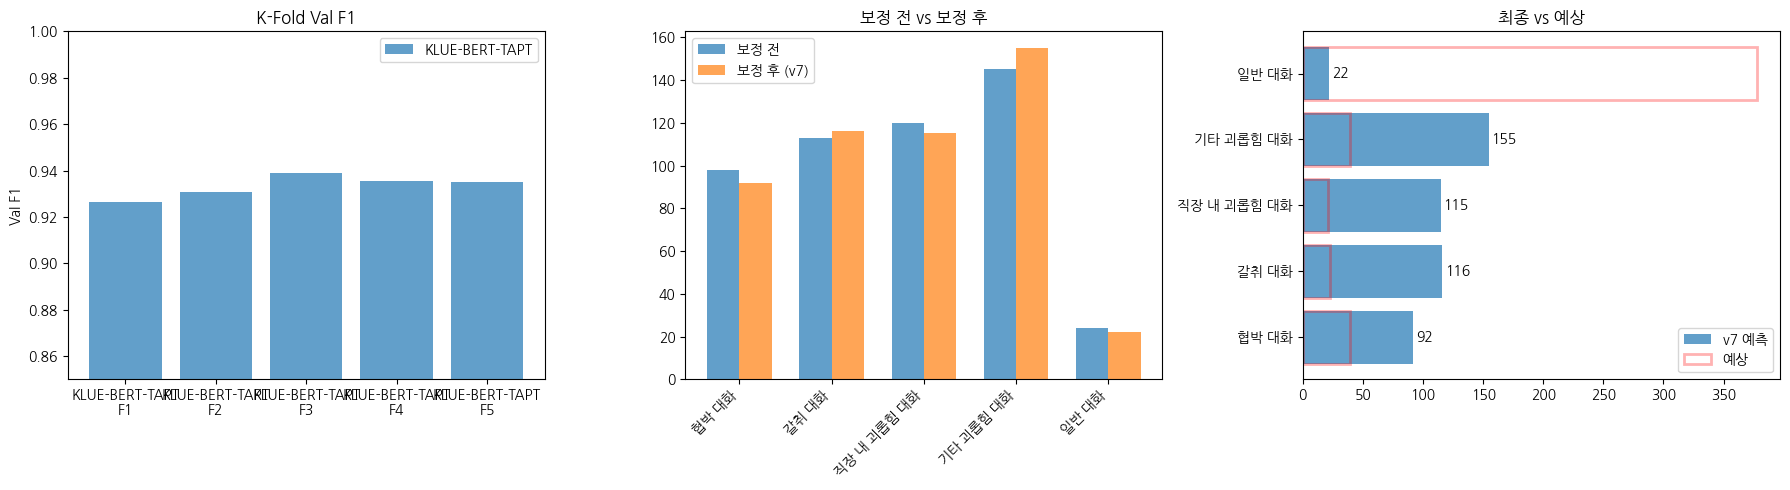

In [17]:
# ============================================================
# STEP 10: 결과 시각화
# ============================================================
try:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    ax = axes[0]
    for mc in MODEL_CONFIGS:
        ms = mc['short']
        ff = [r['best_val_f1'] for r in all_fold_results if r['model'] == ms]
        ax.bar([f"{ms}\nF{i+1}" for i in range(len(ff))], ff, alpha=0.7, label=ms)
    ax.set_ylabel('Val F1')
    ax.set_title('K-Fold Val F1')
    ax.legend()
    ax.set_ylim(0.85, 1.0)

    ax = axes[1]
    ln = [IDX2CLASS[i] for i in range(NUM_CLASSES)]
    x = np.arange(NUM_CLASSES)
    rv = [Counter(raw_preds).get(i, 0) for i in range(NUM_CLASSES)]
    fv = [fc.get(i, 0) for i in range(NUM_CLASSES)]
    w = 0.35
    ax.bar(x - w/2, rv, w, label='보정 전', alpha=0.7)
    ax.bar(x + w/2, fv, w, label='보정 후 (v7)', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(ln, rotation=45, ha='right')
    ax.set_title('보정 전 vs 보정 후')
    ax.legend()

    ax = axes[2]
    ev = [EST_TEST_DIST[i] for i in range(NUM_CLASSES)]
    ax.barh(ln, fv, alpha=0.7, label='v7 예측')
    ax.barh(ln, ev, alpha=0.3, label='예상',
            edgecolor='red', linewidth=2, fill=False)
    ax.set_title('최종 vs 예상')
    ax.legend()
    for i, v in enumerate(fv):
        ax.text(v + 2, i, str(v), va='center')

    plt.tight_layout()
    plt.savefig('v7_results.png', dpi=150)
    plt.show()
except Exception as e:
    print(f"시각화 오류: {e}")
    print("시각화 건너뜀")

In [18]:
print("=" * 60)
print("  DKTC v7 프로젝트 정리")
print("=" * 60)
print(f"\n  [v7-1] TAPT: klue/bert-base + MLM 사전학습 ({TAPT_EPOCHS}ep)")
print(f"  [v7-2] 대규모 일반대화: korean_safe_conversation + KOTE + 기존 소스")
print(f"  [v7-3] 모델: {BASE_MODEL} (0.882 달성 참고)")
print(f"\n  [v3] K-Fold({N_FOLDS}F) + R-Drop + Focal Loss")
print(f"  [v4] LLRD={LLRD_FACTOR}, FGM={FGM_EPSILON}, EMA={EMA_DECAY}, LS={LABEL_SMOOTHING}")
print(f"  [v5] Prior Calibration, Confidence Fallback")
print(f"  [v6] Hard Negative 200개, Hard Sample Mining, Dynamic Class Weight")
try:
    _avg = np.mean([r['best_val_f1'] for r in all_fold_results])
    print(f"\n  평균 Val F1: {_avg:.4f}")
except Exception:
    pass
print(f"  제출파일: submission_v7.csv")
print(f"\n  참고:")
print(f"  - https://ratsgo.github.io/embedding/downloaddata.html")
print(f"  - https://github.com/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC")
print(f"\n  완료!")

  DKTC v7 프로젝트 정리

  [v7-1] TAPT: klue/bert-base + MLM 사전학습 (5ep)
  [v7-2] 대규모 일반대화: korean_safe_conversation + KOTE + 기존 소스
  [v7-3] 모델: klue/bert-base (0.882 달성 참고)

  [v3] K-Fold(5F) + R-Drop + Focal Loss
  [v4] LLRD=0.95, FGM=1.0, EMA=0.999, LS=0.05
  [v5] Prior Calibration, Confidence Fallback
  [v6] Hard Negative 200개, Hard Sample Mining, Dynamic Class Weight

  평균 Val F1: 0.9334
  제출파일: submission_v7.csv

  참고:
  - https://ratsgo.github.io/embedding/downloaddata.html
  - https://github.com/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC

  완료!


In [19]:
output_path = '/home/william/jupyterlab-home/submission_v7.csv'
print(f"제출파일 위치: {output_path}")
print(f"파일 크기: {os.path.getsize(output_path):,} bytes")

제출파일 위치: /home/william/jupyterlab-home/submission_v7.csv


FileNotFoundError: [Errno 2] No such file or directory: '/home/william/jupyterlab-home/submission_v7.csv'